In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,Conv1D, MaxPool1D

import string
from string import punctuation
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings

warnings.filterwarnings("ignore")

# EDA & Text Preprocessing

In [72]:
fake = pd.read_csv("/Users/dianalevy/Downloads/572515-1037534-bundle-archive/Fake.csv")
real = pd.read_csv("/Users/dianalevy/Downloads/572515-1037534-bundle-archive/True.csv")

The data is first uploaded into separate datasets, one containing only the real news articles, the other containing the fake articles

In [73]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [74]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Noticing that most real articles have publishers printed before the actual text ending with a '-', so first we will identify the few who have no publisher listed and save those indices in a list

In [75]:
#create a list of indices where no publisher is listed in text
no_publisher = []
for i, row in enumerate(real.text.values):
    try:
        record = row.split(" -",maxsplit=1)
        record[1]
        #if length of publication part is greater than 260 (discounting any tweets), an error will occur 
        #and all " -" has been counted
        assert(len(record[0])< 260)
    except:
        no_publisher.append(i)
    

In [76]:
#23 articles have no publisher
real.iloc[no_publisher].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [77]:
publisher = []
temp = []
for i, row in enumerate(real.text.values):
    if i in no_publisher:
        temp.append(row)
        publisher.append('na')
        
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    temp.append(record[1])
        
real['publisher'] = publisher
real['text'] = temp

In [78]:
del publisher, temp, record, no_publisher

In [79]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [80]:
ind = [ind for ind, text in enumerate(real.text.values) if str(text).strip()=='']
real = real.drop(ind, axis = 0)

fake_ind = [ind for ind, text in enumerate(fake.text.values) if str(text).strip()=='']
fake = fake.drop(fake_ind,axis=0)

#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

Total Records:	21416
Total Records:	22851


In [81]:
real_df = real.copy()
fake_df = fake.copy()

def combine(df):
    df['text']=df['title']+' '+df['text']
    del df['subject']
    del df['date']
    return df

real_df = combine(real_df)
fake_df = combine(fake_df)

## Stopwords - removing of common words that add no additional importance to the text meaning. Examples include words like 'the', 'and', 'he', 'she', 'like', etc.

In [82]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [84]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def clean(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

real_df['text']=real_df.text.apply(clean)
fake_df['text']= fake_df.text.apply(clean)

## WordCloud - Wordcloud highlights the most used words in a set of documents. The larger the word is, the more often the word was seen in that document

WORD CLOUD for REAL NEWS:



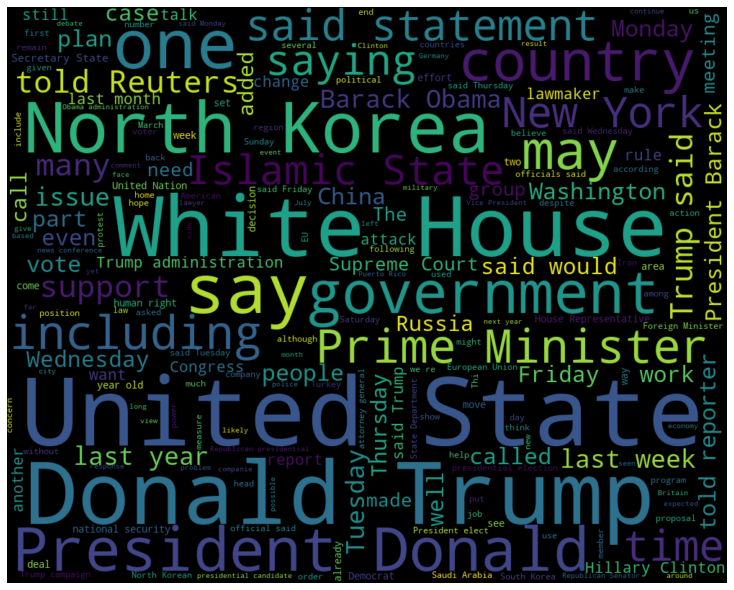

WORD CLOUD for FAKE NEWS:



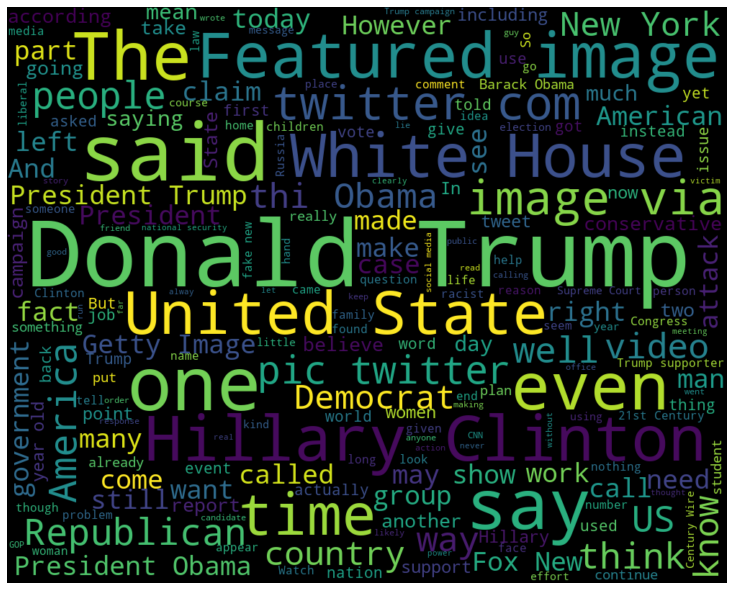

In [85]:
def word_cloud(df):
    wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black',
                      stopwords = STOPWORDS).generate(" ".join(df.text))
    plt.figure(figsize = (10,12))
    plt.imshow(wordcloud, interpolation= 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
print("WORD CLOUD for REAL NEWS:\n")
word_cloud(real_df)
print("WORD CLOUD for FAKE NEWS:\n")
word_cloud(fake_df)

## Next, we'll make sure to combine both real and fake csv files and add a new column 'target' to identify whether article is real or fake

In [98]:
#Attach labels to dataset
real['target']=0
fake['target']=1

#Merge datasets
df = pd.concat([real,fake]) 

In [99]:
pattern1 = "http"
filter1 = df['date'].str.contains(pattern1)

df = df[~filter1]

pattern2 = "Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec"
filter2 = df['date'].str.contains(pattern2)

df = df[filter2]

df['date'] = pd.to_datetime(df['date'])

## Check for category balance to make sure our dataset is a good candidate for training/testing

Text(0, 0.5, 'Article Count')

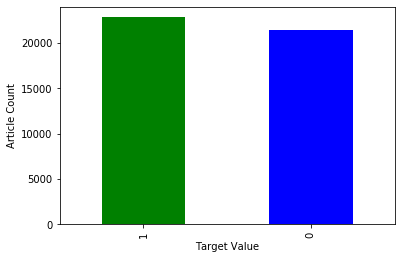

In [100]:
df['target'].value_counts().plot(kind = 'bar', color = ['g','b'])
plt.xlabel('Target Value')
plt.ylabel('Article Count')

## It looks as if our dataset has about the same number of real vs. fake news articles, around 20,000 each.

## Next, let's take a look at how the articles differ in subject

In [101]:
df_subject = df.groupby(['subject', 'target'])['text'].count()
df_subject = df_subject.unstack().fillna(0)

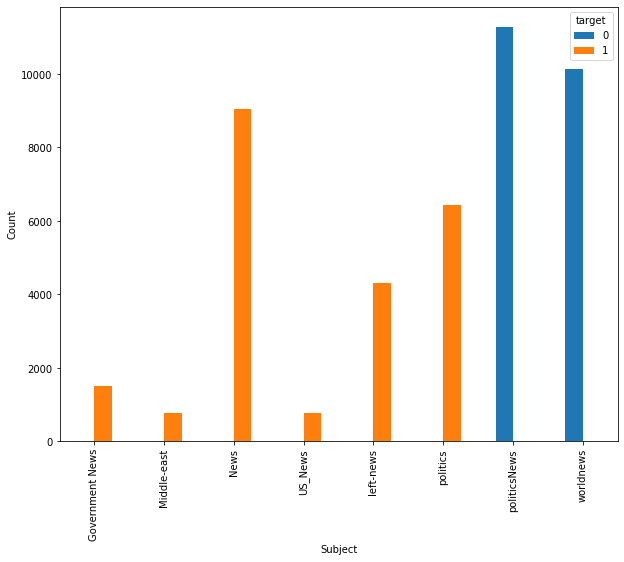

In [102]:
df_subject.plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Subject')
plt.ylabel('Count')
plt.show()

## The real news articles only fall within two subjects (political news and world news), while fake articles fall under the remaining 6 subjects.

## Seeing as the subjects are not the same for the real and fake classes, this feature will not be utilized in our model

## Another visualization for subject category breakdown

In [103]:
import plotly.graph_objects as go

num_real = df_subject[0]
num_fake = df_subject[1]
df_subject['count']=num_real + num_fake

labels = df_subject.index
values = df_subject['count']

pie = go.Pie(labels=labels,values = values)
fig = go.Figure(data=pie)

fig.update_layout(
    title=
    {'text': 'Makeup of Fake/Real News Data',
     'y':0.9,
     'x':0.5,
     'xanchor': 'center',
     'yanchor': 'top'},
    font = {'size':15,'color':'black'})

fig.show()


## Analyzing Publishing Dates - timelines of both real and fake article datasets

In [104]:
df_ = df.copy()
df_ = df_.sort_values(by = ['date'])
df_ = df_.reset_index(drop=True)

In [105]:
df_r = df_[df_['target']==0]
df_r = df_r.groupby(['date'])['target'].count()
df_r = pd.DataFrame(df_r)

In [106]:
df_f = df_[df_['target']==1]
df_f = df_f.groupby(['date'])['target'].count()
df_f = pd.DataFrame(df_f)

## Comparing Fake News vs Real News Timelines

It looks like the real articles were published starting from Jan 2016 to Dec 2017 and the fake articles were pubished from March 2015 to Feb 2018

In [107]:
plot_day = [
    go.Scatter(x = df_r.index, y=df_r.target, name = 'Real'),
    go.Scatter(x = df_f.index, y = df_f.target, name = 'Fake')
]

plot_layout = go.Layout(title = 'Publication of Real vs Fake News',
                       yaxis_title = 'Count',
                       xaxis_title = 'Date',)
fig = go.Figure(data = plot_day, layout = plot_layout)
fig.show()

From the scatterplot above, the number of fake articles released per day remains consistenly higher than the real articles except for notable spikes on November 9, 2016 and from September 2017 to December 2017. The latter spike is most likely due to federal elections for State Senators and Representatives

# Preprocessing the Data 

First, all text will be combined and added to the new 'news' column (except for subject as noted above)

As the title and text columns had words in upper/lower case, all text in 'news' column has been converted to lowercase for future analysis

In addition, we'll clean the complete dataset like we did earlier with the real and fake csv files

In [108]:
df['text'] = df['title']+' '+df['text']

df['text']= df.text.apply(clean)
df['title'] = df.title.apply(clean)

df['text']=df.apply(lambda x: x['text'].lower(),axis=1)
df['title']=df.apply(lambda x: x['title'].lower(),axis=1)

df = df.drop(["subject", "date","publisher"], axis=1)

df.head()

,title,text,target
0,"u.s. budget fight looms, republicans flip fisc...","u.s. budget fight looms, republicans flip fisc...",0
1,u.s. military accept transgender recruits mond...,u.s. military accept transgender recruits mond...,0
2,senior u.s. republican senator: 'let mr. muell...,senior u.s. republican senator: 'let mr. muell...,0
3,fbi russia probe helped australian diplomat ti...,fbi russia probe helped australian diplomat ti...,0
4,trump wants postal service charge 'much more' ...,trump wants postal service charge 'much more' ...,0


## Article Length Analysis

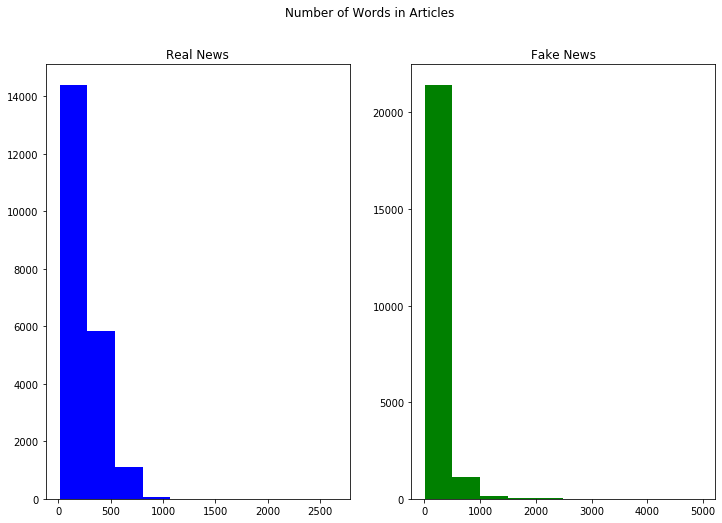

In [109]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(12,8))
real_len = df[df['target']==0]['text'].str.split().map(lambda x:len(x))
ax1.hist(real_len,color = 'blue')
ax1.set_title('Real News')

fake_len = df[df['target']==1]['text'].str.split().map(lambda x:len(x))
ax2.hist(fake_len,color = 'green')
ax2.set_title('Fake News')

fig.suptitle('Number of Words in Articles')
plt.show()

Looking at the distribution of words for both types of articles, it appears a majority of the fake articles are between 0 to 500 words while real articles have a majority from 0 to 250 words

# Word Frequency Dataframe

To analyze word importance, we'll create a corpus that consists of all unique words from our text dataset (after it's been cleaned of distractors - i.e. stopwords, punctuation) and each word's frequency within all documents 

In [110]:
import unicodedata
from nltk.stem import WordNetLemmatizer

def corpus(text):
    words = []
    for doc in text:
        for sentence in doc.split():
            words.append(sentence.strip())
            
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

words = corpus(df.text)
real_words = corpus(df[df['target']==0].text)
fake_words = corpus(df[df['target']==1].text)

real_titles = corpus(df[df['target']==0].title)
fake_titles = corpus(df[df['target']==1].title)

Analyzing top words from both real and fake news data

In [28]:
top = pd.DataFrame(pd.Series(words).value_counts())
top_all = top.head(25)
top_all.head(10)

,0
trump,113033
said,93450
would,55088
u.s.,50334
president,47635
state,46190
republican,36542
people,35363
one,34849
new,31340


Analyzing top words used in all 'Real' news articles

In [29]:
top_real = pd.DataFrame(pd.Series(real_words).value_counts())
top_real = top_real.head(25)
top_real.head(10)

,0
said,72046
u.s.,42041
trump,40909
would,31589
state,28139
president,24154
said.,21583
republican,20971
government,16585
new,16536


Analyzing top words used in all 'Fake' news articles

In [30]:
top_fake = pd.DataFrame(pd.Series(fake_words).value_counts())
top_fake = top_fake.head(25)
top_fake.head(10)

,0
trump,72124
would,23499
president,23481
people,22831
one,22781
said,21404
state,18051
like,17733
obama,17638
donald,17601


## Visualing top words

In [31]:
def plot_words(words,title):
    plot_data = [
    go.Bar(x = words.index, y = words[0],
          marker = dict(color = words[0]))
    ]

    plot_layout = go.Layout(title = title,
                       yaxis_title = 'Count',
                       xaxis_title = 'Words',
                       plot_bgcolor='rgba(0,0,0,0)')
    fig = go.Figure(data = plot_data, layout = plot_layout)
    fig.show()
    
plot_words(top_real,'Top 25 Real Words')
plot_words(top_fake,'Top 25 Fake Words')

# Embedding Layer for Neural Network - Word2Vec
Input text is vectorized into word vectors in order for the text to be utilized and readable by the neural network model

Word2Vec preserves relationships between words, allows for new words to be added to the vocabulary, and better results compared to bag-of-words model


## Tokenizer - Mapping Words to Indices 

In [173]:
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize
from gensim.models import Word2Vec

y = df.target.values
X = []
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

for word in df.text.values:
    temp = []
    sentences = sent_tokenize(word)
    for sentence in sentences:
        sentence = sentence.lower()
        tokens = tokenizer.tokenize(sentence)
        filtered = [word.strip() for word in tokens if word not in stop_words and len(word)>1]
        temp.extend(filtered)
    X.append(temp)
    
DIMEN = 100
w2v = Word2Vec(sentences = X, size = DIMEN,window = 5, min_count=5)

The length of the vocabulary of our data set - all unique words

In [33]:
print(len(w2v.wv.vocab))

46091


In [34]:
w2v.wv.most_similar('reuters')

[('reporters', 0.6593112349510193),
 ('politico', 0.5467792749404907),
 ('cnbc', 0.5463995933532715),
 ('wnd', 0.5177135467529297),
 ('ap', 0.5097771286964417),
 ('thedcnf', 0.500270426273346),
 ('guardian', 0.4933698773384094),
 ('cnnmoney', 0.47090232372283936),
 ('telephone', 0.47078847885131836),
 ('thewrap', 0.46520090103149414)]

In [35]:
w2v.wv.most_similar('washington')

[('huffington', 0.5984601378440857),
 ('clothesline', 0.5388086438179016),
 ('mortem', 0.47537633776664734),
 ('moscow', 0.4544121325016022),
 ('rheinische', 0.42848852276802063),
 ('draining', 0.39677101373672485),
 ('oklahomans', 0.3951128125190735),
 ('israel', 0.38866955041885376),
 ('beijing', 0.3659933805465698),
 ('2017washington', 0.3635443449020386)]

All similar words to 'reuters' tend to be other publications like 'the examiner', 'post', and 'politico'. Ideally, these words should be removed as fake news articles tend to not have publisher name written in the text column

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

Example of word to index mapping

In [37]:
#mapping words to index
word_index =tokenizer.word_index
for word, ind in word_index.items():
    print(f"{word} : {ind}")
    if ind == 10:
        break

trump : 1
said : 2
president : 3
would : 4
people : 5
one : 6
state : 7
new : 8
also : 9
obama : 10


## We need to decide the maximum word length for each of our articles so that our input to the neural network is in perfect matrix form, where each article (N) is the same length (D), so that (N x D) matrix is our input

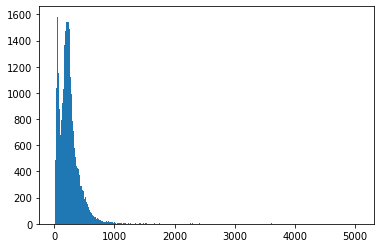

In [38]:
plt.hist([len(x) for x in X], bins=500)
plt.show()


It appears a majority of the articles are less than 1000 words long (this was also apparent in the earlier histograms of real vs fake independently). The maxlen variable will thus be set to 700 to encompass a majority of the words while a minority will be truncated to fit. The pad_sequences function will add 0 to the corresponding indices of words for articles with lengths shorter than 700 words

In [39]:
maxlen = 700
X = pad_sequences(X, maxlen=maxlen)
vocab_size = len(tokenizer.word_index)+1

In [40]:
print(len(X[0]), len(X[1]), len(X[2]))

700 700 700


## Creation of a weight matrix for our Word2Vec model input
1 is added to the vocab size to account for the 0 padding

In [41]:
embed_size = 100 
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, embed_size))
    for word, i in vocab.items():
        if word in model.wv.vocab:
            weight_matrix[i] = model[word]
    return weight_matrix

#Creating a matrix with our w2v model and entire dataset vocabulary
embed_vect = get_weight_matrix(w2v, word_index)
embed_vect.shape

(118317, 100)

## Building the LSTM Neural Network

In [42]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


Using TensorFlow backend.


In [43]:
lstm = Sequential()
lstm.add(Embedding(vocab_size, output_dim = 100, weights = [embed_vect], 
                    input_length = maxlen, trainable = False))

lstm.add(LSTM(units = 128,dropout=0.2))
lstm.add(Dense(1,activation = 'sigmoid'))
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
lstm.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          11831700  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 11,949,077
Trainable params: 117,377
Non-trainable params: 11,831,700
_________________________________________________________________


In [44]:
hist = lstm.fit(Xtrain,ytrain,validation_split = 0.3,epochs=10,batch_size=256)#, callbacks = [early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 23234 samples, validate on 9958 samples
Epoch 1/10
23234/23234 [==============================] - 275s 12ms/sample - loss: 0.2000 - acc: 0.9238 - val_loss: 0.1180 - val_acc: 0.9589
Epoch 2/10
23234/23234 [==============================] - 284s 12ms/sample - loss: 0.1082 - acc: 0.9641 - val_loss: 0.0865 - val_acc: 0.9730
Epoch 3/10
23234/23234 [==============================] - 275s 12ms/sample - loss: 0.0851 - acc: 0.9714 - val_loss: 0.0937 - val_acc: 0.9671
Epoch 4/10
23234/23234 [==============================] - 266s 11ms/sample - loss: 0.1103 - acc: 0.9573 - val_loss: 0.0826 - val_acc: 0.9720
Epoch 5/10
23234/23234 [==============================] - 264s 11ms/sample - loss: 0.0671 - acc: 0.9771 - val_loss: 0.0661 - val_acc: 0.9767
Epoch 6/10
23234/23234 [==============================] - 263s 11ms/sample - loss: 0.0501 - acc: 0.9835 - val_loss: 0.0510 - val_acc: 0.9844
Epoch 7/10


## Predictions 
Class is 0 (real) if probability is less than 0.5, otherwise class is 1

In [45]:
pred =  lstm.predict_classes(Xtest)
print("Accuracy Score: %.2f" % accuracy_score(ytest,pred))
print(classification_report(ytest,pred, target_names = ['Real', 'Fake']))

Accuracy Score: 0.99
              precision    recall  f1-score   support

        Real       0.99      0.98      0.99      5317
        Fake       0.98      0.99      0.99      5748

    accuracy                           0.99     11065
   macro avg       0.99      0.99      0.99     11065
weighted avg       0.99      0.99      0.99     11065



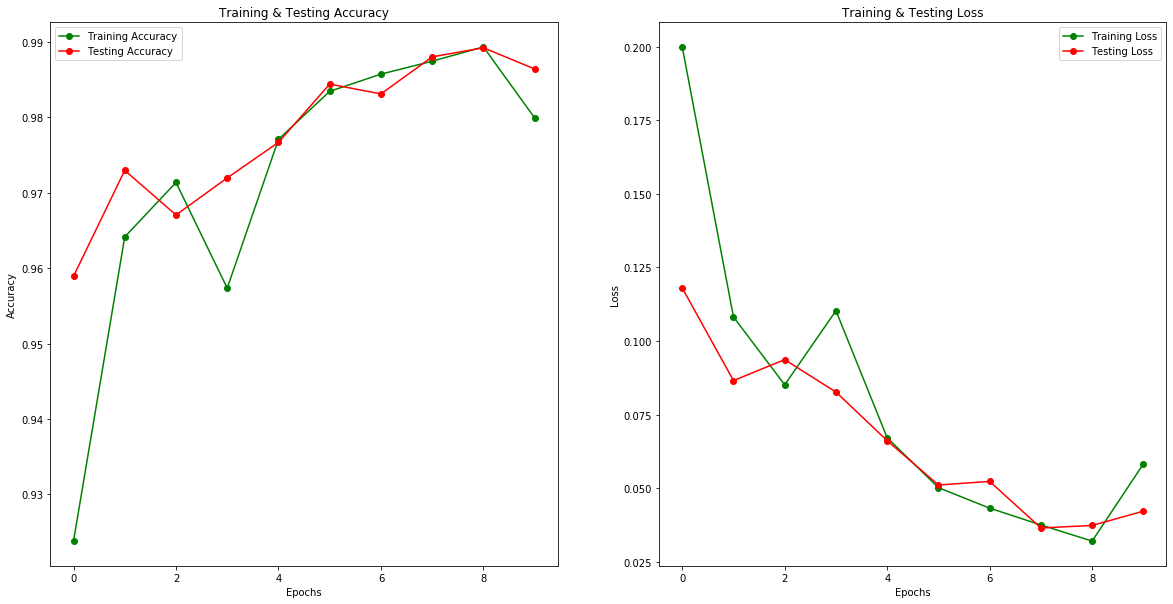

In [47]:
epochs = [i for i in range(len(hist.epoch))]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['acc']
train_loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Text(69.0, 0.5, 'Actual')

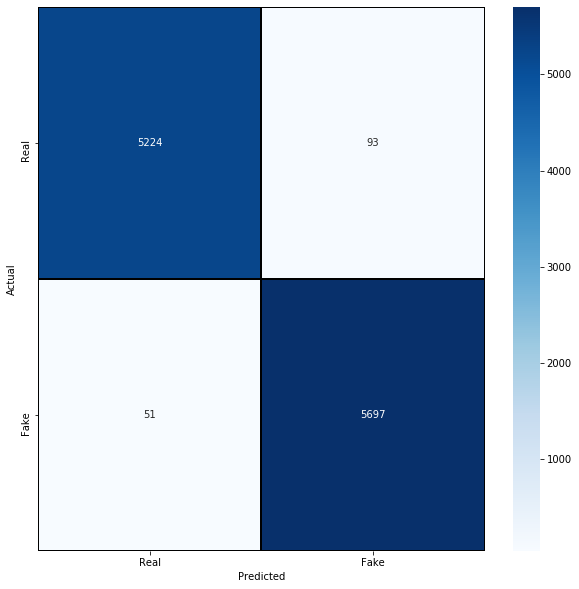

In [48]:
cm = confusion_matrix(ytest,pred)
cm = pd.DataFrame(cm , index = ['Real','Fake'] , columns = ['Real','Fake'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , 
            xticklabels = ['Real','Fake'] , yticklabels = ['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

As reported above, 93 of the 5317 real news articles were predicted to be fake while 51 of the 5748 fake articles were predicted to be real

Our model was a little better at predicting fake articles compared to real

# LSTM #2 - Training on Article Title

In [111]:
top_real_titles = pd.DataFrame(pd.Series(real_titles).value_counts())
top_fake_titles = pd.DataFrame(pd.Series(fake_titles).value_counts())

In [187]:
top_real_titles=top_real_titles.head(25)
top_fake_titles=top_fake_titles.head(25)
plot_words(top_real_titles,'Top 25 Real Title Words')
plot_words(top_fake_titles,'Top 25 Fake Title Words')

In [157]:
y = df.target.values
X_ = []
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

for word in df.title.values:
    temp = []
    sentences = sent_tokenize(word)
    for sentence in sentences:
        sentence = sentence.lower()
        tokens = tokenizer.tokenize(sentence)
        filtered = [word.strip() for word in tokens if word not in stop_words and len(word)>1]
        temp.extend(filtered)
    X_.append(temp)
    
DIMEN = 100
w2v_ = Word2Vec(sentences = X_, size = DIMEN,window = 5, min_count=1)



In [128]:
tokenizer_ = Tokenizer()
tokenizer_.fit_on_texts(X_)
X_ = tokenizer_.texts_to_sequences(X_)
word_index_ =tokenizer_.word_index



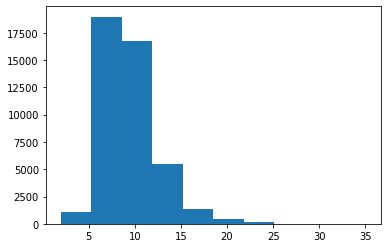

In [129]:
plt.hist([len(x) for x in X_], bins=10)
plt.show()



In [130]:
maxlen_ = 25
X_ = pad_sequences(X_, maxlen=maxlen_)
vocab_size_ = len(tokenizer_.word_index)+1

print(len(X_[0]), len(X_[1]), len(X_[2]))

25 25 25


In [133]:
embed_vect_ = get_weight_matrix(w2v_, word_index_)
embed_vect_.shape

(20656, 100)

In [137]:
lstm_ = Sequential()
lstm_.add(Embedding(vocab_size_, output_dim = 100, weights = [embed_vect_], 
                    input_length = maxlen_, trainable = False))

lstm_.add(LSTM(units = 128,dropout=0.2))
lstm_.add(Dense(1,activation = 'sigmoid'))
lstm_.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
X_train, X_test, y_train, y_test = train_test_split(X_,y)

hist_ = lstm_.fit(X_train,y_train,validation_split = 0.3,epochs=12)

Train on 23234 samples, validate on 9958 samples
Epoch 1/12
23234/23234 [==============================] - 25s 1ms/sample - loss: 0.3892 - acc: 0.8192 - val_loss: 0.3386 - val_acc: 0.8520
Epoch 2/12
23234/23234 [==============================] - 24s 1ms/sample - loss: 0.3345 - acc: 0.8521 - val_loss: 0.3329 - val_acc: 0.8519
Epoch 3/12
23234/23234 [==============================] - 24s 1ms/sample - loss: 0.3145 - acc: 0.8627 - val_loss: 0.2965 - val_acc: 0.8705
Epoch 4/12
23234/23234 [==============================] - 28s 1ms/sample - loss: 0.3013 - acc: 0.8672 - val_loss: 0.3010 - val_acc: 0.8675
Epoch 5/12
23234/23234 [==============================] - 23s 1ms/sample - loss: 0.2887 - acc: 0.8753 - val_loss: 0.2785 - val_acc: 0.8796
Epoch 6/12
23234/23234 [==============================] - 24s 1ms/sample - loss: 0.2739 - acc: 0.8821 - val_loss: 0.2688 - val_acc: 0.8839
Epoch 7/12
23234/23234 [==============================] - 25s 1ms/sample - loss: 0.2653 - acc: 0.8858 - val_loss: 0.2

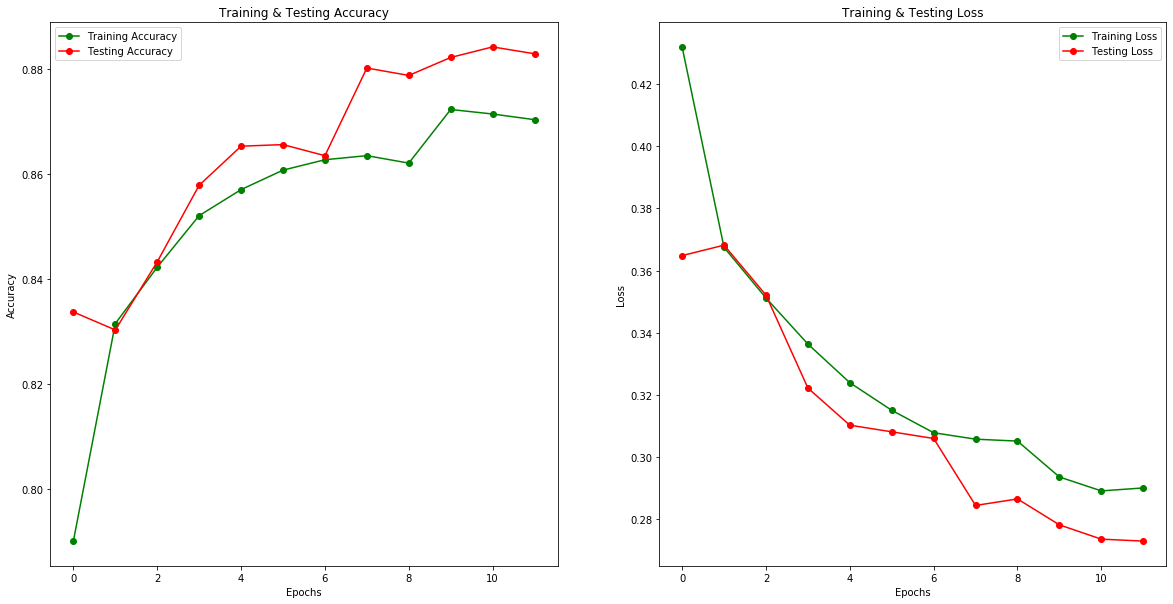

In [136]:
epochs = [i for i in range(len(hist_.epoch))]
fig , ax = plt.subplots(1,2)
train_acc = hist_.history['acc']
train_loss = hist_.history['loss']
val_acc = hist_.history['val_acc']
val_loss = hist_.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [140]:
pred_ =  lstm_.predict_classes(X_test)
print("Accuracy Score: %.2f" % accuracy_score(y_test,pred_))
print(classification_report(y_test,pred_, target_names = ['Real', 'Fake']))


Accuracy Score: 0.90
              precision    recall  f1-score   support

        Real       0.86      0.95      0.90      5333
        Fake       0.95      0.85      0.90      5732

    accuracy                           0.90     11065
   macro avg       0.90      0.90      0.90     11065
weighted avg       0.91      0.90      0.90     11065



Text(69.0, 0.5, 'Actual')

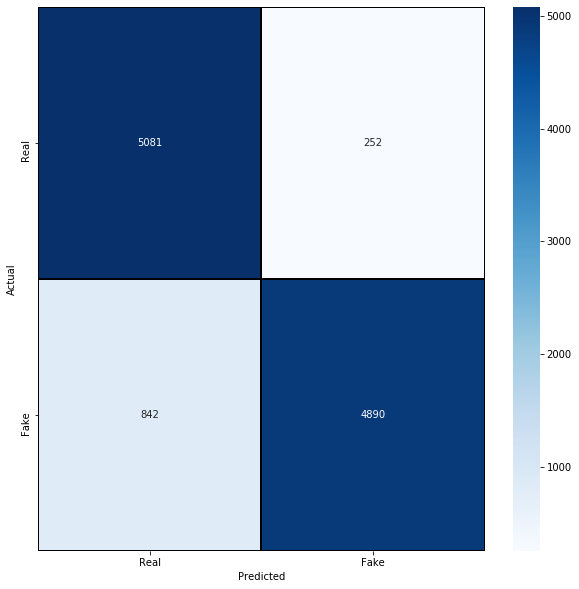

In [141]:
cm_ = confusion_matrix(y_test,pred_)
cm_ = pd.DataFrame(cm_ , index = ['Real','Fake'] , columns = ['Real','Fake'])
plt.figure(figsize = (10,10))
sns.heatmap(cm_,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , 
            xticklabels = ['Real','Fake'] , yticklabels = ['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Testing Additional Models

retrieve all titles again and transform into integer vectors with CountVectorizer

In [181]:
X1 = df.title.values

In [182]:
cv = CountVectorizer()
X_vect = cv.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X_vect, y)

In [183]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
pred_mnb = mnb.predict(X_test)

lr = LogisticRegression()
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)
print('Multinomial NB: ',accuracy_score(y_test,pred_mnb))
print('LR:',accuracy_score(y_test,pred_lr))

Multinomial NB:  0.9401717126073204
LR: 0.9508359692724808


## Multinomial NB Classification Report

In [184]:
print(classification_report(y_test,pred_mnb, target_names = ['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.95      0.93      0.94      5426
        Fake       0.93      0.95      0.94      5639

    accuracy                           0.94     11065
   macro avg       0.94      0.94      0.94     11065
weighted avg       0.94      0.94      0.94     11065



## Logistic Regression Model Classification Report

In [185]:
print(classification_report(y_test,pred_lr, target_names = ['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.94      0.96      0.95      5426
        Fake       0.96      0.94      0.95      5639

    accuracy                           0.95     11065
   macro avg       0.95      0.95      0.95     11065
weighted avg       0.95      0.95      0.95     11065



## Logistic Regression Model Confusion Matrix

Text(69.0, 0.5, 'Actual')

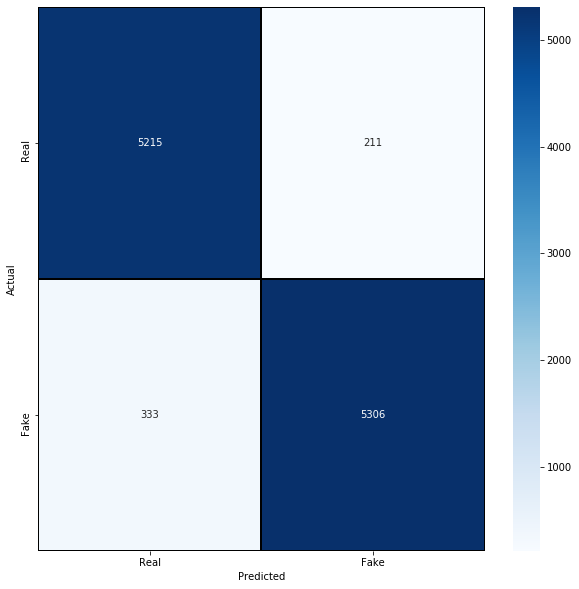

In [186]:
cm_lr = confusion_matrix(y_test,pred_lr)
cm_lr = pd.DataFrame(cm_lr , index = ['Real','Fake'] , columns = ['Real','Fake'])
plt.figure(figsize = (10,10))
sns.heatmap(cm_lr,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , 
            xticklabels = ['Real','Fake'] , yticklabels = ['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")